# Bear 3 - Model Fingerprinting

Welcome to the "Bear 3 - Model Fingerprinting" challenge, where your skills in exploiting AI systems will be put to the test. In this tutorial, you'll learn how to determine the specific type of machine learning model being used by an API endpoint. Identifying a model's architecture and preprocessing steps is crucial for understanding its strengths and weaknesses. This knowledge enables a security professional to anticipate potential vulnerabilities, tailor attacks or defenses, and optimize their interactions with the model without excessive querying that could lead to detection or access denial.

## Challenge Description

In this challenge, you are provided with access to an image classifier hosted on a popular bear-themed social networking site. The site's API allows you to upload images and returns the probability that the depicted subject is a brown bear. Your task is to uncover the inner workings of this classifier:

## Objective

You are given access to an image classifier hosted on a bear social networking site. If you send this endpoint an image, it will respond with the probability that the bear is a `brown bear`. You are interested in understanding exacly which model that this website is using so that you can run further experiments on it without needing to constantly trigger the endpoint, risking having your account banned.

Your objective is to leverage the outputs from the API model to identify the exact image preprocessing and model being used on the bear social networking site. Once you believe you've identified the model being used you can unlock the flag by submitting the probabiliy of the second provided image `ping_pong.png` prediction of being a ping pong ball.

## Understand Model Fingerprinting

### Black Box vs. White Box Models
- **Black Box Model**: In this context, a black box model is one where the internal architecture and parameters are unknown to you. You interact with it only through its API, observing inputs and outputs without access to the underlying code or weights. This is typical in real-world scenarios where security professionals must assess external systems.

- **White Box Model**: Contrary to the black box, a white box model is fully exposed to the investigator. It includes complete access to the model’s architecture, weights, and even the training data. This scenario is ideal for internal audits and in-depth security assessments where transparency is required.

In this tutorial, you will use techniques typically applied to black box scenarios to infer the white box details of the model based solely on its behavior.

## Setup

In order to interact with the challenge, you will need your API Key.

You can find this key in the Crucible platform in this challenge.

[https://crucible.dreadnode.io/challenges/bear3](https://crucible.dreadnode.io/challenges/bear3)

In [1]:
CRUCIBLE_API_KEY = "Xg5cjQoamNuVJ-FlCnbKtO5rzu8u_xzi"  # Replace with your actual API key

### Install Required Packages

Install the required packages.


In [2]:
%pip install requests --quiet
%pip install pillow==9.5.0 --quiet 
%pip install timm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Set Notebook Variables

Set the variables used throughout the notebook


In [3]:
CHALLENGE = "bear3"
CRUCIBLE_URL = "https://crucible.dreadnode.io"
CHALLENGE_URL = "https://bear3.crucible.dreadnode.io"
ARTIFACT_FILES = ['brown_bear.png', 'ping_pong.png']

### Download Data

Before diving into data analysis, you'll need to download the necessary dataset for this challenge.

In [4]:
import requests


for artifact in ARTIFACT_FILES:
    url = f"{CRUCIBLE_URL}/api/artifacts/{CHALLENGE}/{artifact}"
    headers={"X-API-Key": CRUCIBLE_API_KEY}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(artifact, "wb") as file:
            file.write(response.content)
        print(f"{artifact} was successfully downloaded")
    else:
        print(f"Failed to download {artifact}")

brown_bear.png was successfully downloaded
ping_pong.png was successfully downloaded


In [5]:
# Import necessary libraries
from PIL import Image
import base64
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Verify Download
Ensure that the images are downloaded successfully by listing them:

In [6]:
!ls -l | grep .png

-rw-r--r--@ 1 keagansuah  staff  1884903 Oct 26 14:14 brown_bear.png
-rw-r--r--@ 1 keagansuah  staff   847710 Oct 26 14:14 ping_pong.png
-rw-r--r--  1 keagansuah  staff  1658218 Oct 26 01:40 temp.png


## Test the endpoint

To understand the behavior of the model behind the API, we will first visualize the provided images and then test them against the endpoint.

### Display Images

Let’s examine the images to confirm their content before sending them to the model:

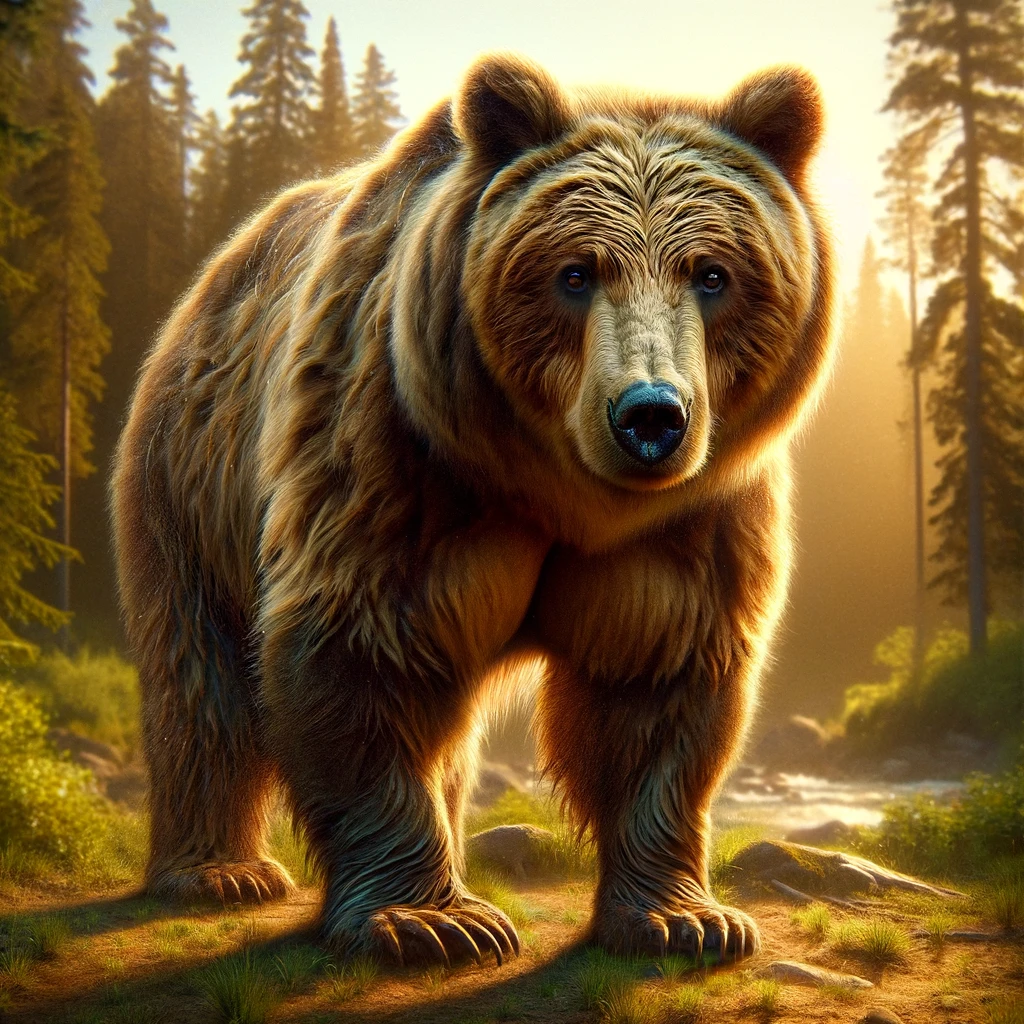

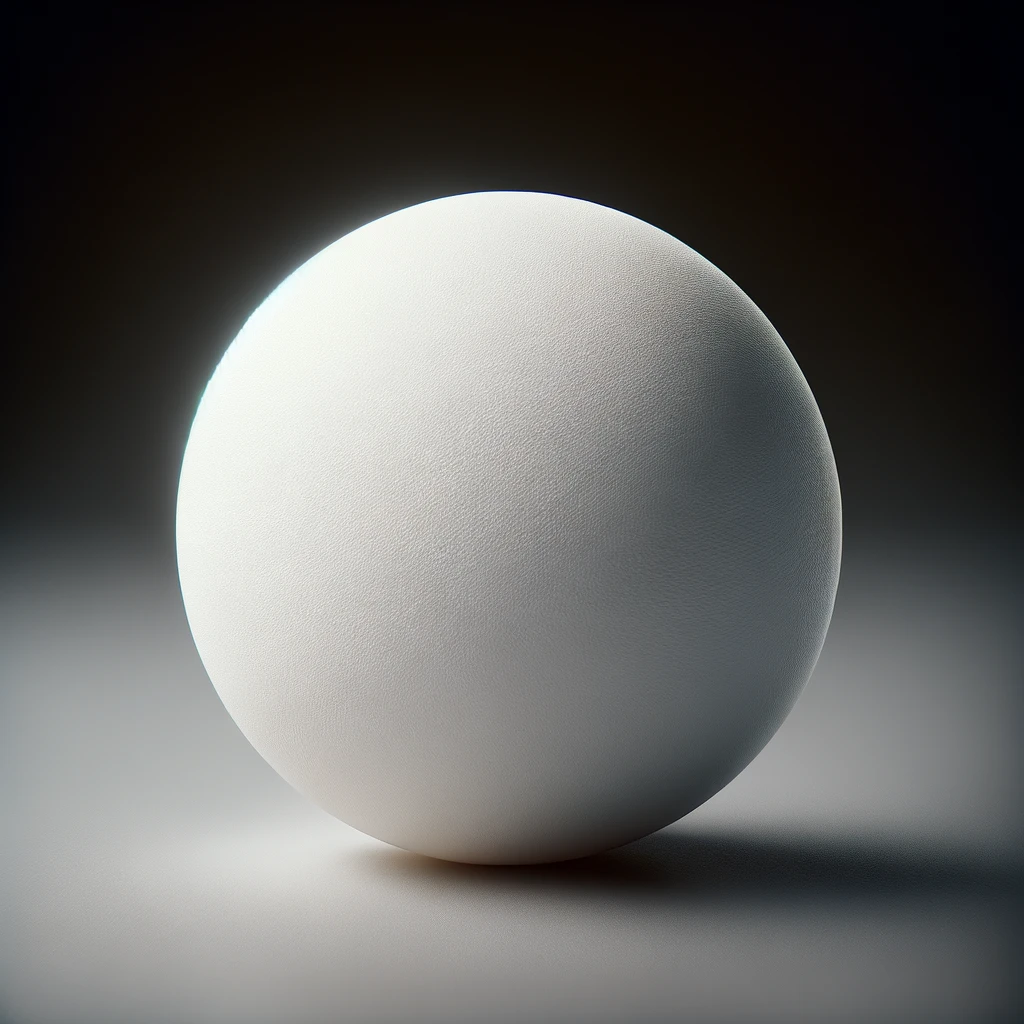

In [7]:
# Display the 'brown_bear.png' image
im = Image.open("brown_bear.png")
display(im)

# Display the 'ping_pong.png' image
im = Image.open("ping_pong.png")
display(im)

### Send Requests to the Endpoint

We need to encode the images in base64 format before sending them through the API. Below is a demonstration of how to prepare and send a request.

In [8]:
# Read the image and b64 encode to send to the endpoint
def get_encoded_image(image_filename):
    with open(image_filename, "rb") as f:
        image = base64.b64encode(f.read())
    return image


def query(input_data):
    response = requests.post(
        "https://bear3.crucible.dreadnode.io/score",
        headers={"X-API-Key": CRUCIBLE_API_KEY},
        json={"data": input_data},
    )
    return response.json()


# Test query with 'brown_bear.png'
image_data = get_encoded_image("brown_bear.png")
response = query(image_data.decode())
print("Response for 'brown_bear.png': ", response)

# Test query with 'ping_pong.png'
image_data = get_encoded_image("ping_pong.png")
response = query(image_data.decode())
print("Response for 'ping_pong.png': ", response)

Response for 'brown_bear.png':  {'brown bear': 0.9997809529304504}
Response for 'ping_pong.png':  {'brown bear': 2.3639397568331333e-06}


This testing section allows you to see how the API responds to images that the model identifies as a brown bear and how it handles images of other subjects. It sets the stage for deeper analysis as you proceed to model fingerprinting in the following sections.

## Fingerprinting Approach

The core objective of this tutorial is to identify the underlying model used by the Bear3 API endpoint. Ideally, we aim to replicate the model's entire processing pipeline so that our local setup can predict outcomes as accurately as the endpoint.

## Probe the model endpoint

Model fingerprinting involves determining the specifics of the model by observing how it responds to various inputs. This can be achieved through multiple strategies:

1. **Using Random Images**: Observing how the model reacts to completely random images.
2. **Applying Minor Modifications**: Making slight alterations to known images and studying the model's responses.
3. **Utilizing Random Noise**: Sending images composed of random noise and analyzing the outputs.
4. Any other method that would examine the input/output relationship of the endpoint.

For this tutorial, we'll use a more structured approach by rotating a known image and observing how the model's confidence scores change. This will provide insights into the model's robustness and handling of image transformations.

### Experiment Setup

We'll use the brown_bear.png image, apply different rotations, and record the model's predictions in a pandas DataFrame. This method allows us to visualize the model's sensitivity to image orientation.

Image rotated at angle 0°, score: {'brown bear': 0.9997809529304504}
Image rotated at angle 36°, score: {'brown bear': 0.9876809120178223}
Image rotated at angle 72°, score: {'brown bear': 0.0024739718064665794}
Image rotated at angle 108°, score: {'brown bear': 0.00032598437974229455}
Image rotated at angle 144°, score: {'brown bear': 0.00041149306343868375}
Image rotated at angle 180°, score: {'brown bear': 0.0007431101985275745}
Image rotated at angle 216°, score: {'brown bear': 4.879887274000794e-05}
Image rotated at angle 252°, score: {'brown bear': 0.0004143835394643247}
Image rotated at angle 288°, score: {'brown bear': 0.0009727272554300725}
Image rotated at angle 324°, score: {'brown bear': 0.3915201723575592}


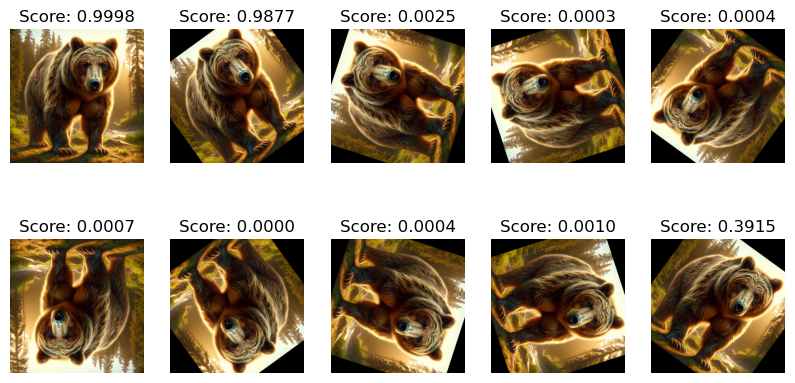

       base_image  rotation  brown_bear_score
0  brown_bear.png       0.0          0.999781
1  brown_bear.png      36.0          0.987681
2  brown_bear.png      72.0          0.002474
3  brown_bear.png     108.0          0.000326
4  brown_bear.png     144.0          0.000411


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import io
import base64

# Initialize tracking DataFrame
tracking = pd.DataFrame()

# Setup plot for visualizing responses
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()

# Load and display the base image
bear_image = Image.open("brown_bear.png")
for i, angle in enumerate(range(0, 360, 36)):
    # Rotate image and encode it to base64
    rotated_image = bear_image.rotate(angle)
    buffered = io.BytesIO()
    rotated_image.save(buffered, format="PNG")
    rotated_image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # Query the model endpoint with the rotated image
    response = query(rotated_image_base64)
    print(f"Image rotated at angle {angle}°, score: {response}")

    # Store response in DataFrame
    tracking.loc[i, "base_image"] = "brown_bear.png"
    tracking.loc[i, "rotation"] = angle
    tracking.loc[i, "brown_bear_score"] = response["brown bear"]

    # Display the rotated image and score
    axs[i].imshow(rotated_image)
    axs[i].set_title(f'Score: {response["brown bear"]:0.4f}')
    axs[i].axis("off")
plt.show()

# Example output logs
print(tracking.head())

## Experiment Result Analysis

By rotating the image and observing the model's response, we can start to understand its handling of orientation changes, which might suggest specific characteristics of the model's training or architecture. For instance, a significant drop in confidence as the image rotates away from an upright position could indicate a lack of rotational invariance, which is common in many image recognition models.

## Pretrained Image Models

### Understand ImageNet

Many image recognition models are pretrained on ImageNet, a vast dataset used in computer vision for training and benchmarking. ImageNet contains over a million labeled images spanning thousands of categories. One of these categories includes "brown bear," which is crucial for our analysis because it directly relates to the challenge at hand.

For further exploration of the "brown bear" category in ImageNet, you can visit: [Salient ImageNet - Brown Bear Class.](https://salient-imagenet.cs.umd.edu/explore/class_294/feature_140.html)

# Set Up Pretrained Models

For this challenge, we will utilize models available through the PyTorch 'timm' library. Understanding the general workflow of image classifiers will aid in replicating the endpoint's model:

1. **Image Preprocessing**: The image is transformed into a numerical array (HxWxC format, where H is height, W is width, and C is channels representing RGB values).
2. **Normalization**: The pixel values are standardized to ensure they match the model’s expected input range, typically using a mean and standard deviation that align with the ImageNet training data.
3. **Model Inference**: The processed image array is fed into the model, which outputs predictions across 1,000 classes.

Below, we provide the preprocessing steps and the function to predict using any given model:

In [10]:
!pip install timm --quiet

In [11]:
import torch
import timm
from PIL import Image
from torchvision import transforms


# Function to load an image and transform it for model inference
def load_and_transform_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension


# Function to perform prediction using a specified model
def predict_image(model_name, image_tensor):
    model = timm.create_model(model_name, pretrained=True)
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
    return logits.argmax(dim=1), logits

### Test Pretrained Models

Let's apply these functions to predict the category of the `brown_bear.png` image using different models:

In [12]:
image_tensor = load_and_transform_image("brown_bear.png")
model_names = ["mobilenetv3_large_100", "efficientnet_b0", "resnet18"]
BROWN_BEAR_INDEX = 294  # Index for brown bear in ImageNet

# Test each model and print out the probability of 'brown bear'
for model_name in model_names:
    prediction, logits = predict_image(model_name, image_tensor)
    probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
    print(f"Prediction from {model_name}: {prediction}")
    print(f"Brown bear probability: {probs[0][BROWN_BEAR_INDEX]:.4f}")

Prediction from mobilenetv3_large_100: tensor([294])
Brown bear probability: 0.9507
Prediction from efficientnet_b0: tensor([294])
Brown bear probability: 0.9438
Prediction from resnet18: tensor([294])
Brown bear probability: 0.9998


The output from these models will help us identify which one resembles the behavior of the Bear3 API endpoint the closest. By comparing these results, we can determine the model that most likely powers the endpoint.

# Fingerprinting offline models

Having established a baseline of how our pretrained models predict the 'brown bear' class, we can further refine our model identification process. This involves comparing the behavior of our local models against the model behind the Bear3 API using the previously rotated images.

## Run Inference on Rotated Images

To systematically compare the models, we'll re-use the rotated images, testing each one with our selected pretrained models. This will help us evaluate how closely each model's responses match the API's output over a range of image orientations.

In [13]:
# Re-using the rotated images to test each offline model
for i, angle in enumerate(range(0, 360, 36)):
    rotated_image = bear_image.rotate(angle)  # Rotate image
    rotated_image.save("temp.png")  # Save as a temporary file
    image_tensor = load_and_transform_image("temp.png")  # Transform image for model inference

    for model_name in model_names:
        prediction, logits = predict_image(model_name, image_tensor)
        probs = torch.softmax(logits, dim=1)
        # Store each model's probability for the brown bear class in tracking DataFrame
        tracking.loc[i, f"{model_name}_score"] = probs[0][BROWN_BEAR_INDEX].item()

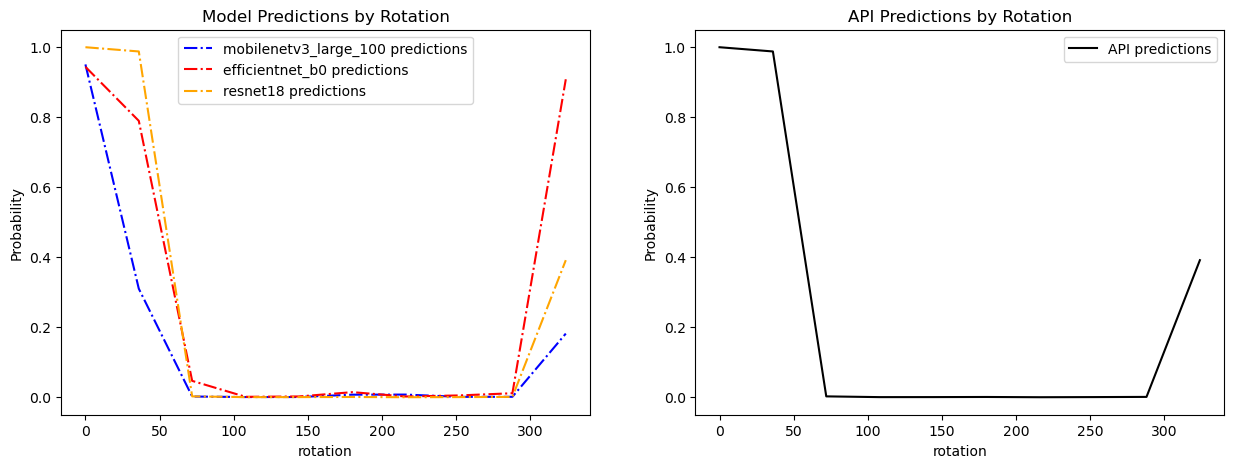

In [14]:
# Plotting the results for visual comparison
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for model_name, color in zip(model_names, ["blue", "red", "orange"]):
    tracking.plot(
        x="rotation",
        y=f"{model_name}_score",
        style="-.",
        label=f"{model_name} predictions",
        ax=axs[0],
        color=color
    )

tracking.plot(
    x="rotation",
    y="brown_bear_score",
    style="-",
    label="API predictions",
    ax=axs[1],
    color="black"
)

axs[0].set_title("Model Predictions by Rotation")
axs[1].set_title("API Predictions by Rotation")
axs[0].set_ylabel("Probability")
axs[1].set_ylabel("Probability")
plt.legend()
plt.show()

## Analyze Correlations

To quantify how closely each model's predictions correlate with the API responses, we compute the correlation coefficient for each model relative to the API. A higher correlation suggests a closer match to the underlying model used by the API.

In [15]:
import numpy as np

# Calculate and print the correlation of each model's scores with the API scores
for model_name in model_names:
    correlation = np.corrcoef(tracking['brown_bear_score'], tracking[f'{model_name}_score'])[0, 1]
    print(f"Correlation of {model_name} with API: {correlation:.4f}")

Correlation of mobilenetv3_large_100 with API: 0.8662
Correlation of efficientnet_b0 with API: 0.9051
Correlation of resnet18 with API: 1.0000


## Local vs API Model Comparison

Upon analyzing the predictions from the `resnet18` model across various image rotations, we observed a strong alignment with the API's responses. This high degree of similarity across all tested conditions strongly indicates that the Bear3 API likely uses a model similar to resnet18.

# Get the Flag

## Predict an Unseen Class

With the model identified, the next step involves using it to predict a category not explicitly related to the primary task. According to the challenge, we should now predict the probability that an image of a ping pong ball (`ping_pong.png`) is recognized as something else. In ImageNet, the "ping pong ball" category is indexed at 722.

For a deeper look at this class, refer to: [Salient ImageNet - Ping Pong Ball Class](https://salient-imagenet.cs.umd.edu/explore/class_722/feature_352.html).

In [16]:
# Load and transform the image
image_tensor = load_and_transform_image("ping_pong.png")
# Make predictions using the identified model
prediction, logits = predict_image('resnet18', image_tensor)
probs = torch.softmax(logits, dim=1)

PING_PONG_IDX = 722
ping_pong_prediction = probs[0][PING_PONG_IDX].item()
print("Predicted resnet18 probability for 'ping pong ball':", ping_pong_prediction)

Predicted resnet18 probability for 'ping pong ball': 0.6980135440826416


### Submit the Prediction to the API

In [17]:
# Function to send the predicted probability to the API and get the flag
def get_flag(pingpong_prob):
    response = requests.post(
        "https://bear3.crucible.dreadnode.io/score",
        headers={"X-API-Key": CRUCIBLE_API_KEY},
        json={"pingpong": pingpong_prob},
    )
    return response.json()

# Fetch the flag using the predicted probability
flag_response = get_flag(ping_pong_prediction)
print("Flag Response:", flag_response)

Flag Response: {'flag': 'gAAAAABnHIlNWWYgbnRTqGbWuc6lDR0ev1vdiSYIy1U81CeaOMGqetqZ8yqqWKfOvUa8_185lgSvvBoWa8B6DGJNhImzwALtUbkGhCgqqZL1sX5qxmw9j0_zg1HWypR76Lbspk2X2sHwAPwxLLUh3HjkkAkzSXIbYMoTIC_cMJIfZnIWaAI8gq0='}


## Submit Your Findings

Submit findings placeholder

In [18]:
import requests


def query(input_data):
    response = requests.post(
        f"{CHALLENGE_URL}/score",
        headers={"Authorization": CRUCIBLE_API_KEY},
        json={"data": input_data}
    )
    return response.json()

response = query("")
print(response)

{'message': 'Unauthorized'}


## Submit Your Flag

When you find the answer, you will get a flag back. It will look something like `gAAAAA ...`.
You can submit it using the code below, or, on the challenge page.

In [19]:
import requests


def submit_flag(flag):
    url = f"{CRUCIBLE_URL}/api/challenges/{CHALLENGE}/submit-flag"
    headers = {"Authorization": CRUCIBLE_API_KEY}
    payload = {"challenge": CHALLENGE, "flag": flag}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        if response.json().get("correct") is True:
            print("The flag was correct. Congrats!")
        else:
            print("The flag was incorrect. Keep trying!")
    else:
        print("There was an error submitting your flag")
        print(response.text)
        
flag = "gAAAAA..."  # Replace with the flag once you find it
submit_flag(flag)

There was an error submitting your flag
{"detail":"Authentication failed","code":401,"type":"authentication_error"}
